In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


### Reading data from kaggle 

In [2]:
df=pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv')

In [3]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


### Deleting columns which we didn't need and changing class to user identified labels

In [4]:
for index,row in df.iterrows():
    if row['class']==0:
        df.loc[index,'label']='hate'       
    elif row['class']==1:
        df.loc[index,'label']='offensive'
    elif row['class']==2:
        df.loc[index,'label']='neither'

In [5]:
df.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither','class'],axis=1,inplace=True)

In [6]:
df

,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive
...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive
24779,"you've gone and broke the wrong heart baby, an...",neither
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive
24781,youu got wild bitches tellin you lies,offensive


In [7]:
df['label'].value_counts()

offensive    19190
neither       4163
hate          1430
Name: label, dtype: int64

### Importing fast AI

In [8]:
from fastai.text.all import *

## As we are using transfer learning in NLP and using ULMFIT method first we have to make our language model which would be trained on pre trained wikipedia model

In [9]:
df_text=df['tweet']

In [10]:
df_text=df_text.to_frame()

## Creating DataBlock 

In [11]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('tweet', is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(0.1) 
    # using only 10% of entire comments data for validation inorder to learn more
)

### Creating DataLoaders

In [12]:
dls_lm = dls_lm.dataloaders(df_text, bs=64, seq_len=72)


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### As it is a language model it will predict the next sentence

In [13]:
dls_lm.show_batch(max_n=3)


,text,text_
0,"xxbos xxup rt @manstagram _ : xxmaj when your trying to resist the urge to smack a bitch http : / / t.co / xxunk xxbos xxunk at least he went up and was n't a bitch xxbos xxmaj maury is funny sometimes , but the ratchet hoes on there need to get knocked the fuck out ! xxbos xxmaj it 's throw it in her throat thursdays so make a ghetto","xxup rt @manstagram _ : xxmaj when your trying to resist the urge to smack a bitch http : / / t.co / xxunk xxbos xxunk at least he went up and was n't a bitch xxbos xxmaj maury is funny sometimes , but the ratchet hoes on there need to get knocked the fuck out ! xxbos xxmaj it 's throw it in her throat thursdays so make a ghetto xxunk"
1,"she had a bf xxrep 4 😂 she 's a hoe on the low xxbos xxmaj some lying ass hoes lol xxbos a xxmaj yankee win makes any day better . xxbos xxup rt xxunk : when an ugly bitch tells me to text her http : / / t.co / xxunk xxbos xxmaj xxunk bitches on xxunk , b / c bitches love xxunk xxbos xxmaj she told me that she","had a bf xxrep 4 😂 she 's a hoe on the low xxbos xxmaj some lying ass hoes lol xxbos a xxmaj yankee win makes any day better . xxbos xxup rt xxunk : when an ugly bitch tells me to text her http : / / t.co / xxunk xxbos xxmaj xxunk bitches on xxunk , b / c bitches love xxunk xxbos xxmaj she told me that she love"
2,"t.co / xxunk ” xxbos xxmaj female xxmaj jihadis , xxmaj european & & xxmaj american : xxup grave xxmaj xxunk ! - xxmaj joe xxmaj for xxmaj america http : / / t.co / xxunk via xxunk xxbos xxunk xxmaj we might have more . xxmaj ca n't really be sure . xxmaj but some weird little bird said that might be a possibility . xxmaj stay xxunk . xxmaj maybe","/ xxunk ” xxbos xxmaj female xxmaj jihadis , xxmaj european & & xxmaj american : xxup grave xxmaj xxunk ! - xxmaj joe xxmaj for xxmaj america http : / / t.co / xxunk via xxunk xxbos xxunk xxmaj we might have more . xxmaj ca n't really be sure . xxmaj but some weird little bird said that might be a possibility . xxmaj stay xxunk . xxmaj maybe ."


In [14]:

learn = language_model_learner(
    dls_lm, AWD_LSTM,
    metrics=[accuracy, Perplexity()]).to_fp16()

### Determining the best learning rate as in Leslie Smith paper

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.019054606556892395)

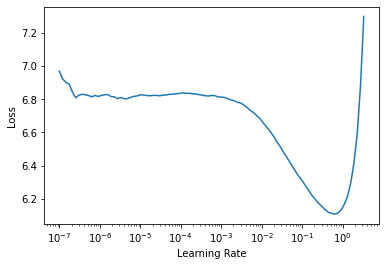

In [15]:
learn.lr_find()


In [16]:
learn.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.862950,4.373511,0.261704,79.321632,00:31


In [17]:
learn.save('1epoch')


Path('models/1epoch.pth')

SuggestedLRs(lr_min=1.737800812406931e-06, lr_steep=1.9054607491852948e-06)

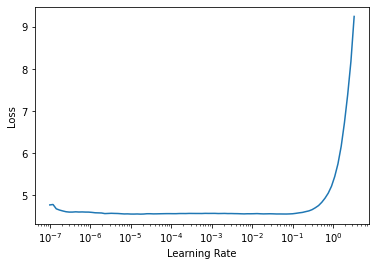

In [18]:
learn.lr_find()


In [19]:
learn.unfreeze()
learn.fit_one_cycle(10,lr_max=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.467519,4.238229,0.276400,69.285057,00:34
1,4.297633,4.103576,0.286223,60.556461,00:34
2,4.129990,4.022853,0.295432,55.860268,00:34
3,3.969481,3.983814,0.298571,53.721512,00:34
4,3.840192,3.964092,0.300998,52.672421,00:34
5,3.738006,3.961870,0.304731,52.555523,00:34
6,3.628636,3.956645,0.308460,52.281628,00:34
7,3.557904,3.958691,0.308326,52.388687,00:34
8,3.486459,3.962316,0.309245,52.578949,00:34
9,3.462817,3.963699,0.308717,52.651730,00:34


### The language model is 30 % accurate. Lets save our encoder

In [20]:
learn.save_encoder('finetuned')


## Let's predict some tweets

In [21]:
TEXT = "i"
N_WORDS = 10
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]


In [22]:
print("\n".join(preds))


i need to stop being a bitch for Halloween though
i was born in Orange County this day ,


## The data is heavily biased towards offensive tweets. Hence we randomly take 3000 tweets from each category

In [23]:
df['label'].value_counts()

offensive    19190
neither       4163
hate          1430
Name: label, dtype: int64

In [24]:
df_offensive = df[df.label== 'offensive']
df_hate = df[df.label== 'hate']
df_neither=df[df.label=='neither']

In [25]:
rows1 = np.random.choice(df_offensive.index.values, 1000)
rows2 = np.random.choice(df_hate.index.values, 1000)
rows3 = np.random.choice(df_neither.index.values, 1000)



In [26]:
df_offensive = df_offensive.loc[rows1]
df_hate = df_hate.loc[rows2]
df_neither=df_neither.loc[rows3]

In [27]:
li=[df_hate,df_offensive,df_neither]
df_new=pd.concat(li)
df_new

,tweet,label
19160,RT @iDntWearCondoms: Stop stalkin your girl social media u bitch ass nigga,hate
13088,My neighbors be sick when i wake um up to all this nigger music ctfu,hate
3400,@Hovaa_ ok wat ever u say whitey. u prolly never even seen shaft.,hate
8938,"Eh bitch!? How about you worry about your own psychotic ass. Looks like you need to ""be saved"" from being a noisy bitch &#9996;&#65039;&#128139; #cantStandUcunt",hate
2324,@2014samanthaKay good enough fag,hate
...,...,...
24615,"trust me, just set the alpha to 0. it's just as good (maybe better) than setting the visibility to false. now: fly on silver bird!",neither
3604,@JamesdaJewison &lt;&lt;BEST NAME ON TWITTER EVER!! AKA; Jewbacca&lt;&lt;SECOND BEST NAME ON TWITTER!!,neither
8528,"Correction:\n&gt;&gt;&gt;&gt;when the sky is yellow, death is upon us. No. I'm scared",neither
6024,@gifs http://t.co/J1PWlaeRCu (via @teapot),neither


## Creating Dataloaders for Classification

In [28]:
dls = TextDataLoaders.from_df(df_new, text_col='tweet', label_col='label',valid_pct=0.1,text_vocab=dls_lm.vocab)


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [29]:
dls.show_batch(max_n=3)


,text,category
0,xxbos xxup rt @bjs xxrep 4 5 : xxup elect xxmaj democratic xxmaj nominee xxmaj charlie xxmaj hardy xxunk to xxup u.s . xxmaj senate . # xxup xxunk xxmaj defeat xxup tea xxmaj mike xxmaj xxunk . # xxunk # xxup xxunk http : / / t.co …,neither
1,xxbos xxmaj my grandma threw out all of my xxunk . xxmaj ones i made from 7th grade to now . xxmaj i 'm literally crying . xxmaj that s all my work in the trash . 😒 😔 😣 😢 😭 xxunk 😡 😤 😠 👿 xxunk 🙍,neither
2,"xxbos xxup rt xxunk : “ xxunk : xxmaj when the trash bag is so full , you can barely tie it … . 😤 😤 http : / / t.co / xxunk ! ! xxup xxunk xxrep 3 o xxup pp ! ! 😳 😂 😂 😭 😭",neither


# Creating our learner 

In [30]:
learn = text_classifier_learner(dls,AWD_LSTM,metrics=accuracy,
                                drop_mult=0.5).to_fp16()


In [31]:
learn = learn.load_encoder('finetuned')


SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0020892962347716093)

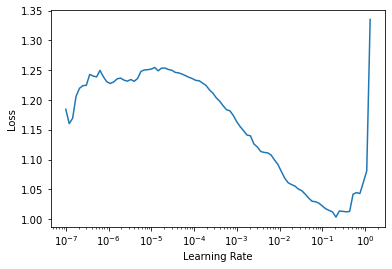

In [32]:
learn.lr_find()

# Using Discriminative training technique

In [33]:
learn.fit_one_cycle(1,2e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.898789,0.735626,0.673333,00:04


In [34]:
learn.freeze_to(-2)
# learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.784711,0.663340,0.720000,00:03


In [35]:
learn.freeze_to(-3)
# learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.709200,0.602556,0.723333,00:03


In [36]:

learn.unfreeze()
# learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.561427,0.564298,0.763333,00:04
1,0.489415,0.443650,0.836667,00:04
2,0.344739,0.445124,0.856667,00:04
3,0.230976,0.416474,0.870000,00:04
4,0.158462,0.421818,0.843333,00:04


# The model predicts each of the classification at more than 80% of times

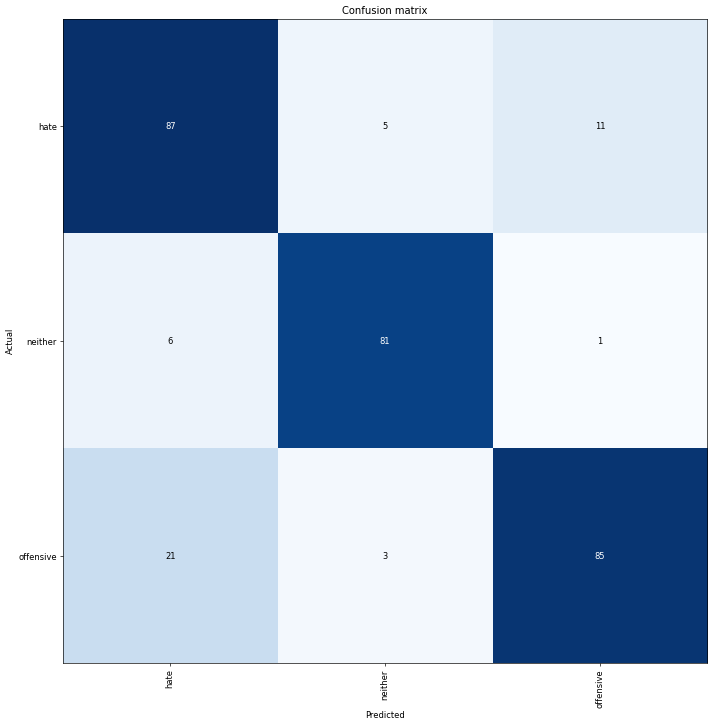

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Lets predict some made up tweets

In [38]:
pr=learn.predict('lets have lunch')

In [39]:
pr

('neither', tensor(1), tensor([0.0191, 0.9749, 0.0061]))

In [40]:
pr=learn.predict('die you mad person')

In [41]:
pr

('hate', tensor(0), tensor([0.9591, 0.0052, 0.0357]))